In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#!pip install scapy
!pip install  --user  seaborn==0.11.0

  Using cached https://files.pythonhosted.org/packages/bc/45/5118a05b0d61173e6eb12bc5804f0fbb6f196adb0a20e0b16efc2b8e98be/seaborn-0.11.0-py3-none-any.whl


In [45]:
#train_df = pd.read_csv("Mar-29-2021.csv", index_col=0)
train_df = pd.read_csv("aioquic-server.csv")
train_df.head()

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
0,0,NaN,server,quic_server_test_version_negociation0,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
1,1,aioquic,server,quic_server_test_retry0,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
2,2,aioquic,server,quic_server_test_version_negociation0,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
3,3,NaN,server,quic_server_test_version_negociation0,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
4,4,NaN,server,quic_server_test_version_negociation0,NaN,+,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0


In [50]:
server_name = train_df.Implementation.unique()
print(server_name)
servers = []
for s in server_name:
    if s  is np.nan:
        pass
    elif "cargo run --manifest-path=tools/apps/Cargo.toml" in s:
        servers.append("quiche")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quiche")
    elif "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    elif "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    elif "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    elif "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    elif "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    elif "python3.10 examples/" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    elif "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")
        
print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)

train_df = train_df[train_df["Implementation"].notna()]
#train_df = train_df[train_df["Implementation"] != "aioquic"]
#train_df = train_df[train_df["Implementation"] != "mvfst"]

print(train_df.size)

for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")

train_df.head()

['aioquic']
[]
1800


,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
1,1,aioquic,server,quic_server_test_retry,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
2,2,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
5,5,aioquic,server,quic_server_test_version_negociation,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
6,6,aioquic,server,quic_server_test_retry,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
11,11,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0


In [51]:
for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")
                        
train_df.head(100)

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
1,1,aioquic,server,quic_server_test_retry,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
2,2,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
5,5,aioquic,server,quic_server_test_version_negociation,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
6,6,aioquic,server,quic_server_test_retry,NaN,NaN,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
11,11,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
12,12,aioquic,server,quic_server_test_retry,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
13,13,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
16,16,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
17,17,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
18,18,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0


In [52]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/"):]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content and not "quic_server_test_connection_close" in resultFile:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'assumption_failed(""' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            c = c.replace("\n","")
            c = c.replace("    ","")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'ivy_return_code(1)+"")' in content:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")
train_df.head()

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
1,1,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
2,2,aioquic,server,quic_server_test_version_negociation,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0
5,5,aioquic,server,quic_server_test_version_negociation,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
6,6,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,0.0,1.0
11,11,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,0.0,0.0


In [53]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        if 'timeout+> client' in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed" 

In [54]:
train_df["Implementation"].unique().tolist()

['aioquic']

In [55]:
train_df.TestName.unique()
train_df["ErrorIEV"].unique().tolist()

['No Error',
 'Handshake not completed',
 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+']

In [56]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/aioquic-server/"):]
            i = i.split("/")[0]
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "aioquic-server/" + str(i) + "_" + row["Implementation"] + "_" + str(row["TestName"]) + ".pcap"
                #print(resultFile)
                if os.path.isfile(resultFile):
                    try:
                        packets = rdpcap(resultFile)
                        ln = len(packets)
                        train_df.loc[index, "NbPktSend"] = ln
                    except:
                        pass
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server2_processed.csv",index=False)
    j += size
    

train_df.head()

200
20
10

0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass
1,1,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,35.0,1.0
2,2,aioquic,server,quic_server_test_version_negociation,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,31.0,0.0
5,5,aioquic,server,quic_server_test_version_negociation,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,41.0,1.0
6,6,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,38.0,1.0
11,11,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,22.0,0.0


In [57]:
train_df["ErrorOUT"] = ""
train_df["ErrorERR"] = ""
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = row["OutputFile"][len("/home/user/Documents/QUIC-FormalVerification/results/"):]
        resultFile = resultFile.replace(".iev",".out")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorOUT"] = content[start_index:end_index+1]
        resultFile = resultFile.replace(".iev",".err")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorERR"] = content[start_index:end_index+1]
                        
train_df.head()

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass,ErrorOUT,ErrorERR
1,1,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,35.0,1.0,,
2,2,aioquic,server,quic_server_test_version_negociation,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,31.0,0.0,,
5,5,aioquic,server,quic_server_test_version_negociation,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,41.0,1.0,,
6,6,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,38.0,1.0,,
11,11,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,22.0,0.0,,


In [58]:
train_df.to_csv(path_or_buf="server2_processed.csv",index=False)

In [59]:
subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_token_error']
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_token_error':
        if row["ErrorIEV"] == "Handshake not completed":
            train_df.loc[i, "isPass"] = 1.0

In [60]:
train_df.TestName.unique()


array(['quic_server_test_retry', 'quic_server_test_version_negociation'],
      dtype=object)

In [61]:
train_df = train_df[train_df.TestName != 'quic_server_test_retirecoid_error']
train_df = train_df[train_df.TestName != 'quic_server_test_newcoid_zero_error']
train_df = train_df[train_df.TestName != 'quic_server_test_blocked_streams_maxstream_error']
train_df = train_df[train_df.TestName != 'quic_server_test_accept_maxdata']
train_df.head()

,Run,Implementation,Mode,TestName,Status,ErrorIEV,OutputFile,NbPktSend,isPass,ErrorOUT,ErrorERR
1,1,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,35.0,1.0,,
2,2,aioquic,server,quic_server_test_version_negociation,NaN,Handshake not completed,/home/user/Documents/QUIC-FormalVerification/r...,31.0,0.0,,
5,5,aioquic,server,quic_server_test_version_negociation,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,41.0,1.0,,
6,6,aioquic,server,quic_server_test_retry,NaN,No Error,/home/user/Documents/QUIC-FormalVerification/r...,38.0,1.0,,
11,11,aioquic,server,quic_server_test_version_negociation,NaN,require ~_generating & ~queued_non_ack(scid) -...,/home/user/Documents/QUIC-FormalVerification/r...,22.0,0.0,,


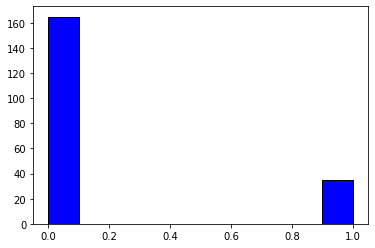

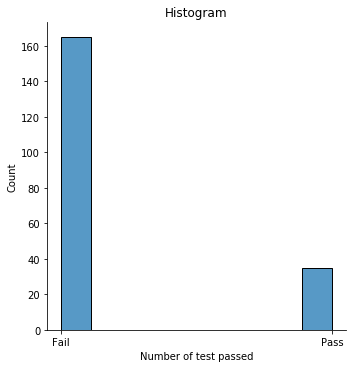

In [62]:
# matplotlib histogram

x = ["Pass","Fail"]

cnt = train_df['isPass'].value_counts()

plt.hist(train_df['isPass'], color = ['blue'], edgecolor = 'black')

# seaborn histogram
sns.displot(train_df['isPass'], kde=False)

plt.xticks(np.arange(0, 2, 1))
positions = (0, 1)
labels = ("Fail", "Pass")
plt.xticks(positions, labels)
# Add labels
plt.title('Histogram')
plt.xlabel('Number of test passed')
plt.ylabel('Count')
plt.show()

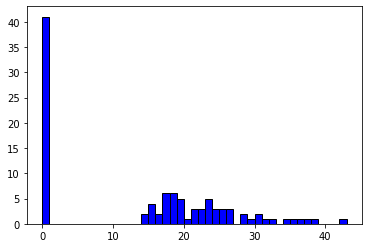

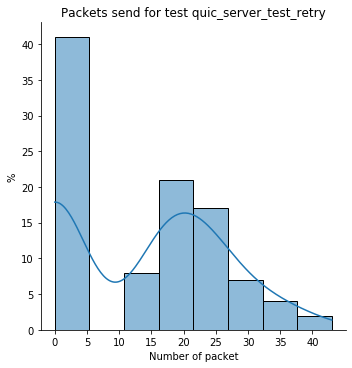

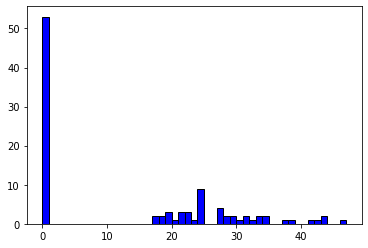

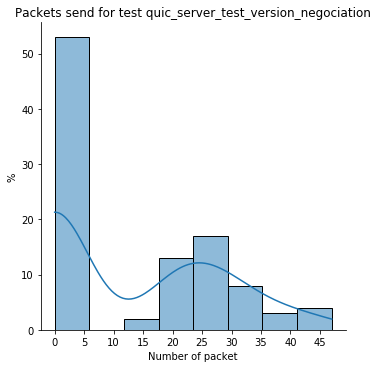

In [63]:
# Failure per test

train_df.TestName.unique()
tests = train_df.TestName.unique()
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.displot(subdf['NbPktSend'],
                 kde=True)
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('Number of packet')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + '.png'
    #plt.savefig(filename)
    plt.show()

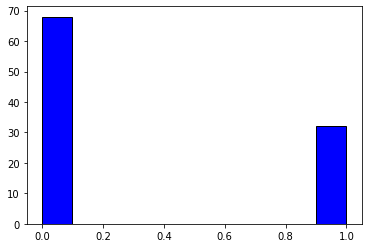

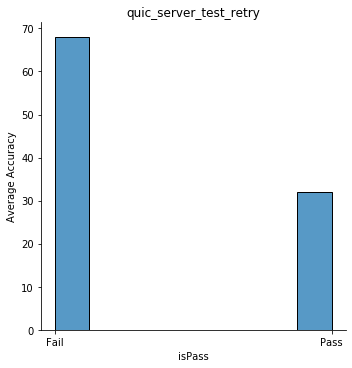

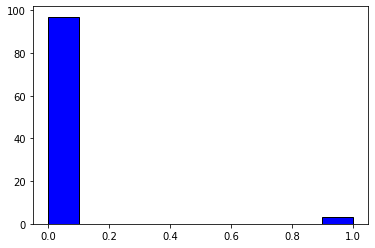

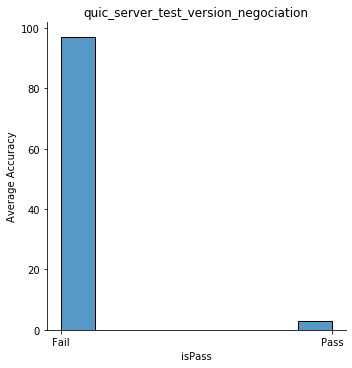

In [64]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()

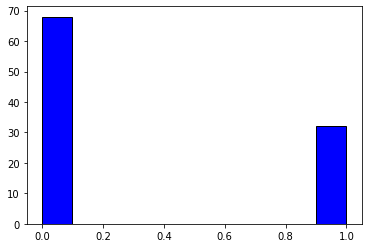

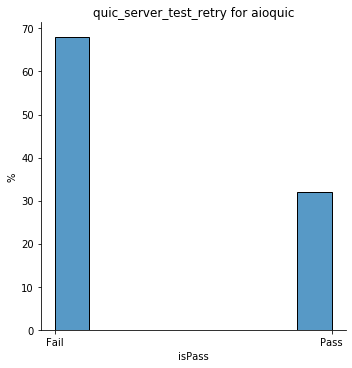

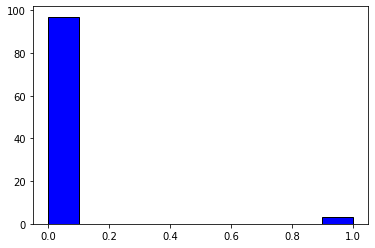

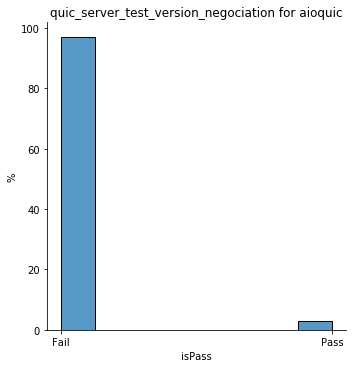

In [65]:
# Failure per test and per implementation

train_df.Implementation.unique()
tests = train_df.TestName.unique()

servers = train_df.Implementation.unique()
#plt.figure(figsize=[10,10]) 'lsquic',
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.displot(subsubdf['isPass'], kde=False)
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + t + "_for_" + s + '.png'
        #plt.savefig(filename)

        plt.show()
    

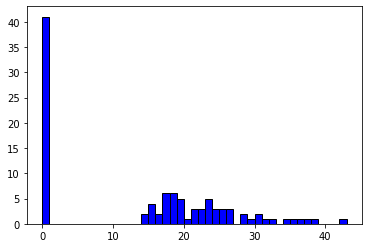

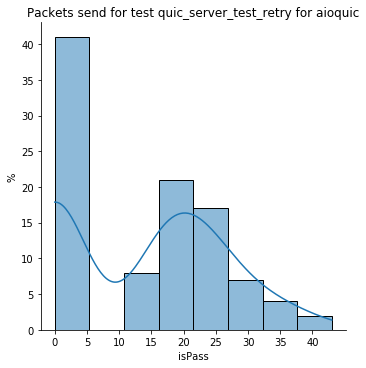

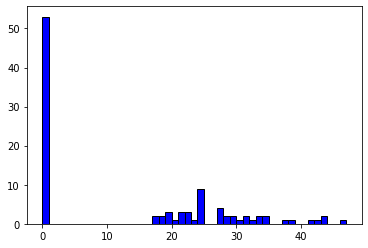

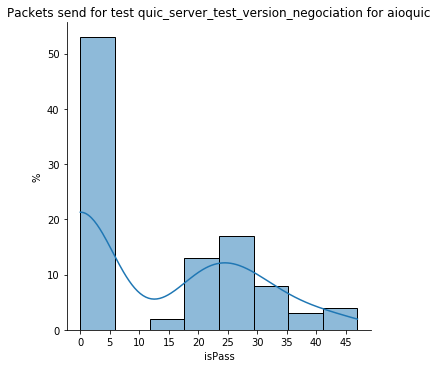

In [66]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        max_value = subsubdf["NbPktSend"].max() 
    
        plt.hist(subsubdf['NbPktSend'], color = 'blue', edgecolor = 'black',
                 range = [0,max_value],bins=max(int(max_value),1))

        # seaborn histogram
        sns.displot(subsubdf['NbPktSend'], 
                     kde=True)
        # Add labels
        plt.xticks(np.arange(0, int(max_value),5))
        # Add labels
        # plt.xticks(np.arange(0, 1, 1))
        # positions = (0, 1)
        # labels = ("Fail", "Pass")
        # plt.xticks(positions, labels)
        plt.title("Packets send for test " + t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + "packets_" + t + "_for_" + s + '.png'
        #plt.savefig(filename)

        plt.show()

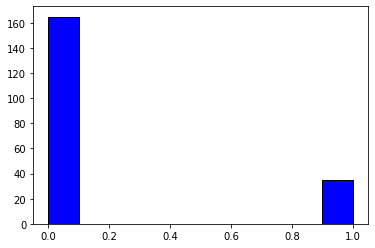

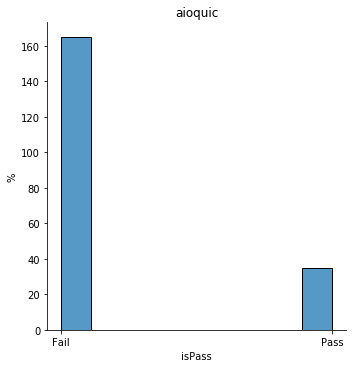

In [67]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('%')
    filename = 'plot/' + t + '.png'
    #plt.savefig(filename)
    plt.show()
    

In [68]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

aioquic
200
35.0



In [69]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    for s in tests:
        ssubdf = subdf.loc[subdf['TestName'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

aioquic
quic_server_test_retry
100
32.0

aioquic
quic_server_test_version_negociation
100
3.0



quic_server_test_retry
aioquic
['No Error', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+', 'Handshake not completed']


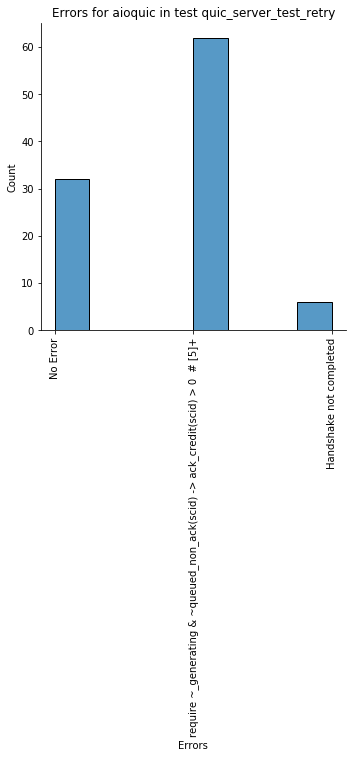

<Figure size 432x288 with 0 Axes>

quic_server_test_version_negociation
aioquic
['Handshake not completed', 'No Error', 'require ~_generating & ~queued_non_ack(scid) -> ack_credit(scid) > 0  # [5]+']


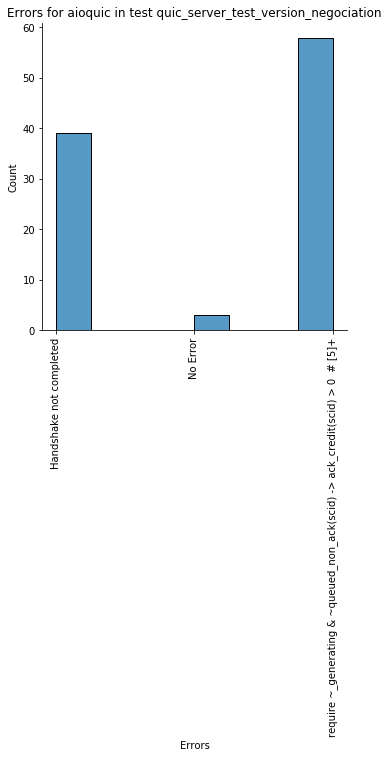

<Figure size 432x288 with 0 Axes>

In [71]:
train_df.Implementation.unique()
tests = train_df.TestName.unique()

servers = train_df.Implementation.unique()
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
                
        # seaborn histogram
        sns.displot(x=subsubdf['ErrorsCode'],  kde=False ) #,hue="Implementation"
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=90)  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        fig = plt.figure()
        plt.show()
        #fig.savefig(filename, dpi=fig.dpi)
